### 0. Imaging the Chandra Data in a Variety of Ways

Using ObsIDS `18689` and `17218`, this notebook creates:
1. `raw merged surface brightness maps`
2. `gaussian smoothed surface brightness maps`
3. `unsharp mask`
4. `soft, medium and hard X-ray maps`
5. `wavelet fit image`
6. `Quantify size of wings in surface brightness image`
7. `If space ebtween wings is a cavity, how much heat injected?`


In [1]:
path_to_beads = '/Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/'

In [2]:
#system
from __future__ import division
import sys

#numpy
import numpy as np

import h5py

#matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import cm
from matplotlib.colors import ListedColormap
from palettable.colorbrewer.qualitative import Set1_4 as brewermap
%matplotlib inline


#astropy
from astropy.wcs import WCS
import astropy.units as u
import astropy.constants as const
from astropy.cosmology import LambdaCDM
from astropy.coordinates import Angle

#pandas
import pandas as pd

#scipy
import scipy

#seaborn
import seaborn as sns 

import importlib


In [3]:
#import my own functions: you can see them in full in the utils folder
util_path = path_to_beads + 'Notebooks/Beads20/utils/'
sys.path.append(util_path)

import plotting_functions as pf
import science_functions as sf

In [4]:
#uncomment if need to reload module
importlib.reload(pf)

<module 'plotting_functions' from '/Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/Notebooks/Beads20/utils/plotting_functions.py'>

In [5]:
#paths
fig_path = path_to_beads + 'Figures/paper/'
chandra_data_directory = '/Users/osaseomoruyi/chandra/alternate_tmap/alternate_spectral_maps_working_dir/merged/'
other_chandra_path = '/Users/osaseomoruyi/chandra/merged/'

In [6]:
#About my galaxy cluster
name = 'SDSS J1531+3414'
ra = 232.7936938
dec = 34.2404172
radius = Angle(2.5, u.arcsec)

zh  = 0.335 #z selected from Hennawi (2008)
cz = zh * const.c.to('km/s') # The stellar systemic velocity that we'll subtract off of our velocity maps. I always use Astropy Units - read up on them if you're not famililar!

cosmo = LambdaCDM(H0=71, Om0=0.27, Ode0=0.73)
da = cosmo.angular_diameter_distance(zh)
dl = cosmo.luminosity_distance(zh)

angular_diameter_distance = cosmo.angular_diameter_distance(z=zh) # in Mpc
kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(z=zh).to(u.kpc / u.arcsec)

In [7]:
#plot style
pf.styleplots()

### Load Data

In [8]:
chandra_smoothed_file = ''.join((chandra_data_directory, 'broad_flux_g1.img'))
chandra_soft_file = ''.join((chandra_data_directory, 'soft_flux.img'))
chandra_medium_file = ''.join((chandra_data_directory, 'medium_flux.img'))
chandra_hard_file = ''.join((chandra_data_directory, 'hard_flux.img'))

chandra_wavelet_file = ''.join((path_to_beads, 'Analysis/chandraBeads/wavelet_fit/beads_lynx_img.fits'))
chandra_raw_file = ''.join((path_to_beads, 'Analysis/chandraBeads/merged/beads_xray_bin2_broad_flux.img'))

chandra_unsharp_mask_file = ''.join((other_chandra_path, 'bin2_broad_flux_unsharpmask.img'))
chandra_g1_file = ''.join((other_chandra_path, 'bin2_broad_flux_g098.img'))
chandra_g10_file = ''.join((other_chandra_path, 'bin2_broad_flux_g98.img'))

In [9]:
csmooth_hdu, csmooth_hdr, csmooth_wcs = pf.open_fits(chandra_smoothed_file)
craw_hdu, craw_hdr, craw_wcs = pf.open_fits(chandra_raw_file)

csoft_hdu, csoft_hdr, csoft_wcs = pf.open_fits(chandra_soft_file)
cmed_hdu, cmed_hdr, cmed_wcs = pf.open_fits(chandra_medium_file)
chrd_hdu, chrd_hdr, chrd_wcs = pf.open_fits(chandra_hard_file)

cwav_hdu, cwav_hdr, cwav_wcs = pf.open_fits(chandra_wavelet_file)

cun_msk_hdu, cun_msk_hdr, cun_msk_wcs = pf.open_fits(chandra_unsharp_mask_file)
cg1_hdu, cg1_hdr, cg1_wcs = pf.open_fits(chandra_g1_file )
cg10_hdu, cg10_hdr, cg10_wcs = pf.open_fits(chandra_g10_file )

In [10]:
#plot HST on top
hst_hdr, hst_wcs, hst_hdu = sf.load_HST_data(path_to_beads)
ysc_coords = sf.ysc_load(path_to_beads)
hst_cont_color, ysc_color = 'k', 'cyan'

### 0. About Data

In [11]:
chandra_data_directory

'/Users/osaseomoruyi/chandra/alternate_tmap/alternate_spectral_maps_working_dir/merged/'

In [18]:
#length of observations
f17218 = ''.join((path_to_beads, 'Analysis/chandraBeads/17218/repro/acisf17218_repro_evt2.fits'))
f18689 = ''.join((path_to_beads, 'Analysis/chandraBeads/18689/repro/acisf18689_repro_evt2.fits'))

c17_hdu, c17_hdr, c17_wcs = pf.open_fits(f17218)
c18_hdu, c18_hdr, c18_wcs = pf.open_fits(f18689)

In [19]:
t_c17 = (abs(c17_hdr['TSTART'] - c17_hdr['TSTOP']) * u.s).to(u.ks)
t_c18 = (abs(c18_hdr['TSTART'] - c18_hdr['TSTOP']) * u.s).to(u.ks)

In [20]:
print(t_c17, t_c18)

65.51954121005535 ks 61.598915980100635 ks


In [22]:
start_date_17, start_date_18 = c17_hdr['DATE-OBS'], c18_hdr['DATE-OBS']
end_date_17, end_date_18 = c17_hdr['DATE-END'], c18_hdr['DATE-END']

print(start_date_17, start_date_18)
print(end_date_17, end_date_18)

2015-10-20T11:52:57 2015-10-28T16:37:56
2015-10-21T06:04:57 2015-10-29T09:44:35


### 1. Raw Merged Surface Brightness

(4180.0, 4500.0)

findfont: Font family ['Computer Modern Roman'] not found. Falling back to DejaVu Sans.


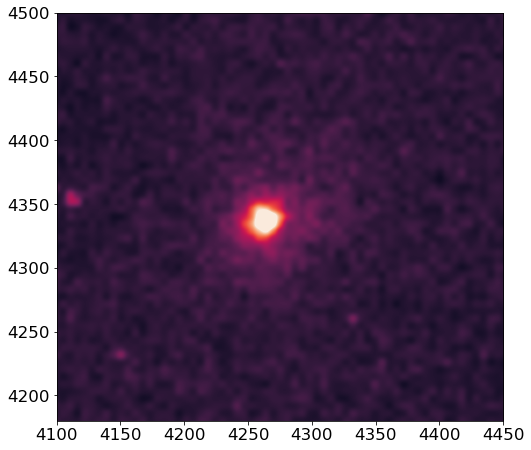

In [12]:
data = craw_hdu.data
x = data['x']
y = data['y']

# binning can be as fine as you want, down to maybe ~1/2 of the native pixel size
nbins = (250, 250)
# I'll explain this more in person

# ALLLLLL images are just 2D histograms! Really!
img_data, yedges, xedges = np.histogram2d(x, y, nbins)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
cmap=sns.color_palette("rocket", as_cmap=True)

fig, ax = plt.subplots()
ax.imshow(img_data, extent=extent, cmap=cmap, vmax=90,
            origin='lower', interpolation='gaussian')

plt.xlim(4100,4450)
plt.ylim(4180,4500)

### 2. Gaussian Smoothed Surface Brightness Map

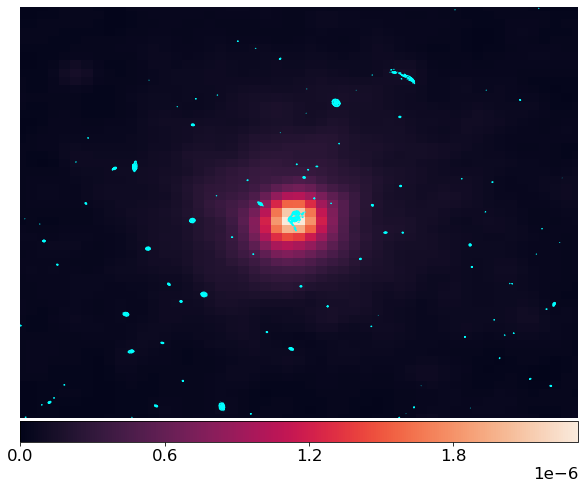

In [66]:
#draw
fig = plt.figure(figsize=(10, 8))
gs1 = GridSpec(1, 1)

cmap=sns.color_palette("rocket", as_cmap=True)
chandra_zoom = [232.7940588,34.2402090, 50 * u.arcsec]

clims=[[None, None]]
data_maps = [csmooth_hdu.data]
axs = []

for id_subplot in range(1):
    clim = clims[id_subplot]
    data = data_maps[id_subplot]

    ax = fig.add_subplot(gs1[id_subplot], projection=WCS(csmooth_hdr))

    ax = pf.ax_fits_map(hdu=None, data=data, hdr=csmooth_hdr,
                        vmin=clim[0], vmax=clim[1], cmap=cmap, 
                        coords=chandra_zoom, ax=ax, contour=False, 
                        clip=None, lw=5, location='bottom')

    #HST Contours: uncomment below lines if not in rush
    pf.overlay(ax, hst_hdu, 1, vmin=0.05, vmax=0.5, nlev=10, contours=True, 
                cont_color='cyan', lw=1)
    ax.axis('off')

### 3. Unsharp Mask

To find evidence of cavities, we create unsharp masks in CIAO for a variety of different bins and smoothed with different gaussians

It was created by dividing the image smoothed with a 0.98" radius Gaussian by one smoothed with a 9.8" Gaussian
- 0.98" - 9.8"
- 1.5" - 8"
- 1.5" - 10"
- 2" - 10"
- 0.7" - 6"
- 1" - 8"
- 1" - 6"

Make in CIAO

Bin 1, Bin2, Bin 4

aconvolve beads_xray_bin2_broad_flux.img bin2_broad_flux_g098.img "lib:gaus(2,5,1,0.98,0.98)" meth=fft mode=h clob+

dmimgcalc bin2_broad_flux_g098.img bin2_broad_flux_g98.img bin2_broad_flux_unsharpmask.img sub clob+  

In [12]:
#unsharp masks

fum_b1_098_98 = ''.join((other_chandra_path, 'bin1_broad_flux_um_098_98.img'))
fum_b1_15_8 = ''.join((other_chandra_path, 'bin1_broad_flux_um_15_8.img'))
fum_b1_15_10 = ''.join((other_chandra_path, 'bin1_broad_flux_um_15_10.img'))
fum_b1_2_10 = ''.join((other_chandra_path, 'bin1_broad_flux_um_2_10.img'))
fum_b1_07_6 = ''.join((other_chandra_path, 'bin1_broad_flux_um_07_6.img'))
fum_b1_1_8 = ''.join((other_chandra_path, 'bin1_broad_flux_um_1_8.img'))
fum_b1_1_6 = ''.join((other_chandra_path, 'bin1_broad_flux_um_1_6.img'))

um_b1_files = [fum_b1_098_98, fum_b1_15_8, fum_b1_15_10, fum_b1_2_10, fum_b1_07_6, 
            fum_b1_1_8, fum_b1_1_6]

fum_b2_098_98 = ''.join((other_chandra_path, 'bin2_broad_flux_um_098_98.img'))
fum_b2_15_8 = ''.join((other_chandra_path, 'bin2_broad_flux_um_15_8.img'))
fum_b2_15_10 = ''.join((other_chandra_path, 'bin2_broad_flux_um_15_10.img'))
fum_b2_2_10 = ''.join((other_chandra_path, 'bin2_broad_flux_um_2_10.img'))
fum_b2_07_6 = ''.join((other_chandra_path, 'bin2_broad_flux_um_07_6.img'))
fum_b2_1_8 = ''.join((other_chandra_path, 'bin2_broad_flux_um_1_8.img'))
fum_b2_1_6 = ''.join((other_chandra_path, 'bin2_broad_flux_um_1_6.img'))

um_b2_files = [fum_b2_098_98, fum_b2_15_8, fum_b2_15_10, fum_b2_2_10, fum_b2_07_6, 
            fum_b2_1_8, fum_b2_1_6]

fum_b4_098_98 = ''.join((other_chandra_path, 'bin4_broad_flux_um_098_98.img'))
fum_b4_15_8 = ''.join((other_chandra_path, 'bin4_broad_flux_um_15_8.img'))
fum_b4_15_10 = ''.join((other_chandra_path, 'bin4_broad_flux_um_15_10.img'))
fum_b4_2_10 = ''.join((other_chandra_path, 'bin4_broad_flux_um_2_10.img'))
fum_b4_07_6 = ''.join((other_chandra_path, 'bin4_broad_flux_um_07_6.img'))
fum_b4_1_8 = ''.join((other_chandra_path, 'bin4_broad_flux_um_1_8.img'))
fum_b4_1_6 = ''.join((other_chandra_path, 'bin4_broad_flux_um_1_6.img'))

um_b4_files = [fum_b4_098_98, fum_b4_15_8, fum_b4_15_10, fum_b4_2_10, fum_b4_07_6, 
            fum_b4_1_8, fum_b4_1_6]

um_labels = ['0.98" - 9.8"', '1.5" - 8"', '1.5" - 10"', '2" - 10"', 
            '0.7" - 6"', '1" - 8"', '1" - 6"']

In [13]:
um_b1_hdus, um_b1_hdrs, um_b1_wcs = [], [], []

for um_file in um_b1_files:
    un_msk_hdu, un_msk_hdr, un_msk_wcs = pf.open_fits(um_file)
    um_b1_hdus.append(un_msk_hdu)
    um_b1_hdrs.append(un_msk_hdr)
    um_b1_wcs.append(un_msk_wcs)

um_b2_hdus, um_b2_hdrs, um_b2_wcs = [], [], []

for um_file in um_b2_files:
    un_msk_hdu, un_msk_hdr, un_msk_wcs = pf.open_fits(um_file)
    um_b2_hdus.append(un_msk_hdu)
    um_b2_hdrs.append(un_msk_hdr)
    um_b2_wcs.append(un_msk_wcs)

um_b4_hdus, um_b4_hdrs, um_b4_wcs = [], [], []

for um_file in um_b4_files:
    un_msk_hdu, un_msk_hdr, un_msk_wcs = pf.open_fits(um_file)
    um_b4_hdus.append(un_msk_hdu)
    um_b4_hdrs.append(un_msk_hdr)
    um_b4_wcs.append(un_msk_wcs)

divide by zero encountered in true_divide
invalid value encountered in true_divide


(342.0, 382.0, 342.0, 382.0)

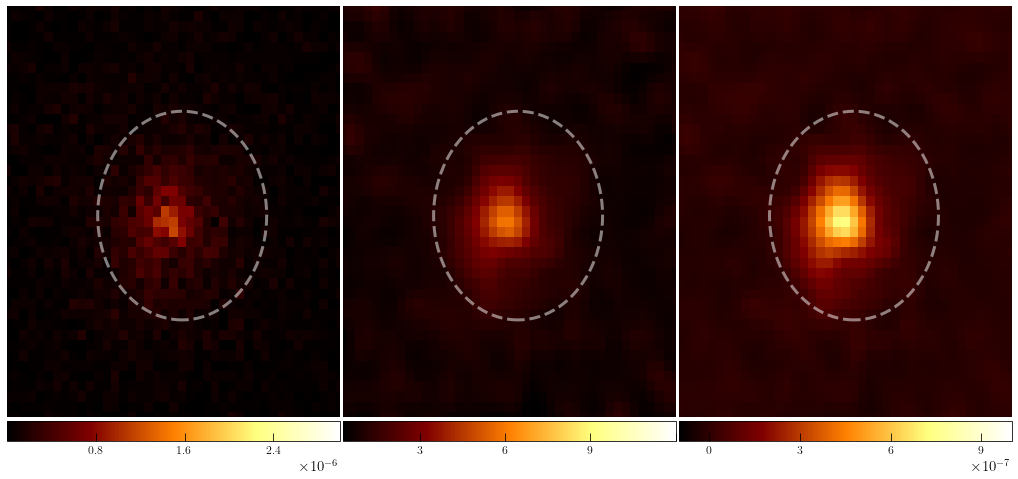

In [78]:
fig = plt.figure(figsize=(18, 8))
gs1 = GridSpec(2, 4)
gs1.update(wspace=0.01)

cmap = cm.afmhot

ax1 = fig.add_subplot(gs1[0], projection=WCS(cg1_hdr))
chandra_zoom = [sf.sdss1531_dict['ra']+ 6e-4, sf.sdss1531_dict['dec'], 20 * u.arcsec]
ax1, cb = pf.ax_fits_map(hdu=None, data=craw_hdu.data, hdr=cg1_hdr,
                vmin=0, vmax=3e-6, cmap=cmap, 
                coords=chandra_zoom, ax=ax1, contour=False, 
                clip=None, location='bottom', cbar=True)
ax1.axis('off')
pf.add_circle(ax1, [sf.sdss1531_dict['ra'], sf.sdss1531_dict['dec']], 10 * u.arcsec, 
                    color='w', coord_frame='fk5', lw=3, alpha=0.5, sphere=True)  

ax2 = fig.add_subplot(gs1[1], projection=WCS(cg1_hdr))
ax2, cb = pf.ax_fits_map(hdu=None, data=cg1_hdu.data/cg10_hdu.data, hdr=cg1_hdr,
                vmin=0.3, vmax=12, cmap=cmap, 
                coords=chandra_zoom, ax=ax2, contour=False, 
                clip=None, location='bottom', cbar=True)
pf.add_circle(ax2, [sf.sdss1531_dict['ra'], sf.sdss1531_dict['dec']], 10 * u.arcsec, 
                    color='w', coord_frame='fk5', lw=3, alpha=0.5, sphere=True)   
ax2.axis('off')

ax3 = fig.add_subplot(gs1[2], projection=WCS(cun_msk_hdr))
ax3, cb = pf.ax_fits_map(hdu=None, data=cun_msk_hdu.data, hdr=cun_msk_hdr,
                vmin=-1e-7, vmax=1e-6, cmap=cmap, 
                coords=chandra_zoom, ax=ax3, contour=False, 
                clip=None, location='bottom', cbar=True)
pf.add_circle(ax3, [sf.sdss1531_dict['ra'], sf.sdss1531_dict['dec']], 10 * u.arcsec, 
                    color='w', coord_frame='fk5', lw=3, alpha=0.5, sphere=True)
ax3.axis('off')

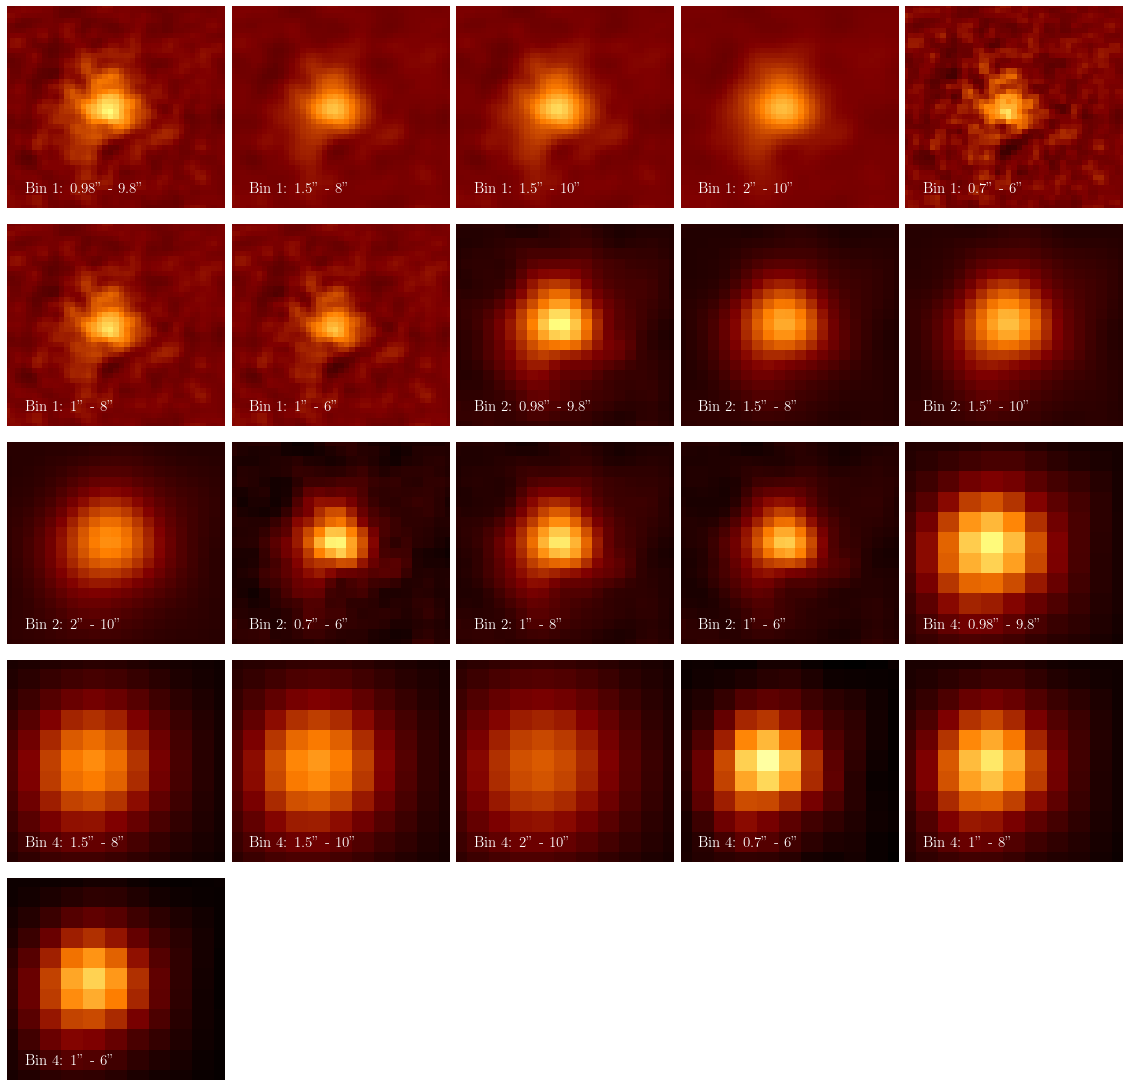

In [50]:
#draw
from socket import has_dualstack_ipv6


fig = plt.figure(figsize=(20, 20))
gs1 = GridSpec(5, 5)
gs1.update(wspace=0.03, hspace=0.01)

cmap = cm.afmhot
chandra_zoom = [232.7940588,34.2402090, 10 * u.arcsec]

clims =[[-1e-7, 3e-7], [-1e-7, 1e-6], [-1e-7, 3e-6]]
files = um_b1_files + um_b2_files + um_b4_files
file_labels = um_labels + um_labels + um_labels
hdus = um_b1_hdus + um_b2_hdus + um_b4_hdus
data_hdrs = um_b1_hdrs + um_b2_hdrs + um_b4_hdrs

data_maps = [unmsk_hdu.data for unmsk_hdu in hdus]
axs = []


# um_hdus, um_hdrs, um_wcs
for id_subplot in range(21):
    if id_subplot < 7:
        clim = clims[0]
    if id_subplot > 6 and id_subplot < 14:
        clim = clims[1]
    if id_subplot > 13 :
        clim = clims[2]
    # um_hdus, um_hdrs, um_wcs
    um_file = files[id_subplot]
    data = data_maps[id_subplot]
    hdr = data_hdrs[id_subplot]

    ax = fig.add_subplot(gs1[id_subplot], projection=WCS(hdr))

    ax, cb = pf.ax_fits_map(hdu=None, data=data, hdr=hdr,
                        vmin=clim[0], vmax=clim[1], cmap=cmap, 
                        coords=chandra_zoom, ax=ax, contour=False, 
                        clip=None, lw=5, location='bottom', 
                        cbar=False)
    # ax.set_title(um_labels[id_subplot])
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    txt = 'Bin {}: {}'.format(um_file[38], file_labels[id_subplot])
    ax.text(xlim[0] + (xlim[1] - xlim[0]) *0.08, ylim[0] + (ylim[1] - ylim[0]) *0.08, 
            txt, color='w')

    # #HST Contours: uncomment below lines if not in rush
    # pf.overlay(ax, hst_hdu, 1, vmin=0.05, vmax=0.5, nlev=10, contours=True, 
    #             cont_color='cyan', lw=1)
    ax.axis('off')

fig.savefig(fig_path + 'chandra_unsharp_masks.pdf')

In [52]:
0.53475/0.2

2.6737499999999996

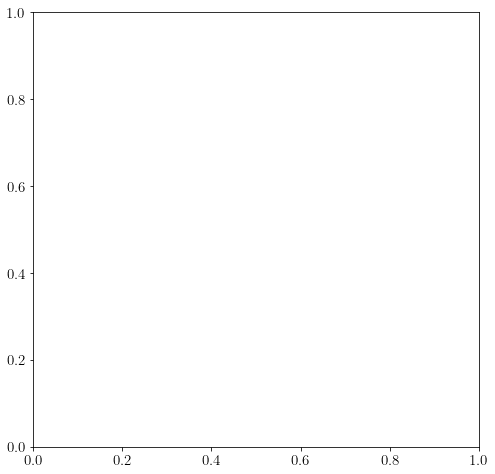

In [25]:
fig, ax = plt.subplots()

In [26]:
ax.text??

Signature: ax.text(x, y, s, fontdict=None, **kwargs)
Docstring:
Add text to the Axes.

Add the text *s* to the Axes at location *x*, *y* in data coordinates.

Parameters
----------
x, y : float
    The position to place the text. By default, this is in data
    coordinates. The coordinate system can be changed using the
    *transform* parameter.

s : str
    The text.

fontdict : dict, default: None
    A dictionary to override the default text properties. If fontdict
    is None, the defaults are determined by `.rcParams`.

Returns
-------
`.Text`
    The created `.Text` instance.

Other Parameters
----------------
**kwargs : `~matplotlib.text.Text` properties.
    Other miscellaneous text parameters.

    Properties:
    agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
    alpha: scalar or None
    animated: bool
    backgroundcolor: color
    bbox: dict with properties for `.patches.FancyBboxPatch`
    clip_box: unkno

Text(0.5, 0.98, 'Bin 2')

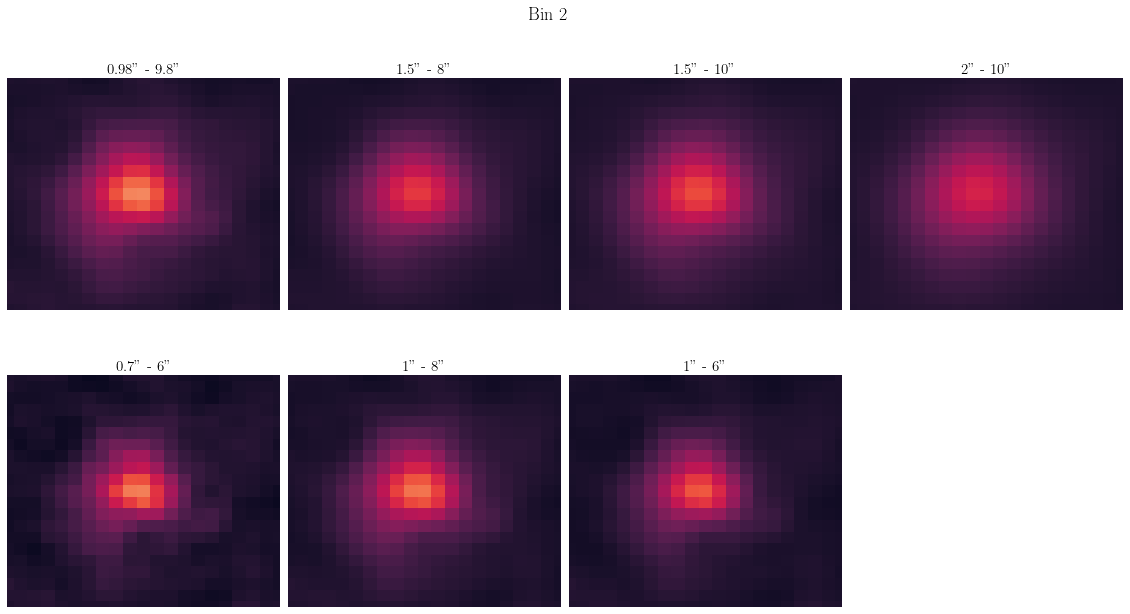

In [102]:
#draw
fig = plt.figure(figsize=(20, 10))
gs1 = GridSpec(2, 4)
gs1.update(wspace=0.03)

cmap=sns.color_palette("rocket", as_cmap=True)
chandra_zoom = [232.7940588,34.2402090, 10 * u.arcsec]

clim =[-1e-7, 1e-6]
data_maps = [unmsk_hdu.data for unmsk_hdu in um_b2_hdus]
data_hdrs = um_b2_hdrs
axs = []


# um_hdus, um_hdrs, um_wcs
for id_subplot in range(7):
    # um_hdus, um_hdrs, um_wcs
    data = data_maps[id_subplot]
    hdr = data_hdrs[id_subplot]

    ax = fig.add_subplot(gs1[id_subplot], projection=WCS(hdr))

    ax, cb = pf.ax_fits_map(hdu=None, data=data, hdr=hdr,
                        vmin=clim[0], vmax=clim[1], cmap=cmap, 
                        coords=chandra_zoom, ax=ax, contour=False, 
                        clip=None, lw=5, location='bottom', 
                        cbar=False)
    ax.set_title(um_labels[id_subplot])
    # #HST Contours: uncomment below lines if not in rush
    # pf.overlay(ax, hst_hdu, 1, vmin=0.05, vmax=0.5, nlev=10, contours=True, 
    #             cont_color='cyan', lw=1)
    ax.axis('off')
fig.suptitle("Bin 2")

Text(0.5, 0.98, 'Bin 4')

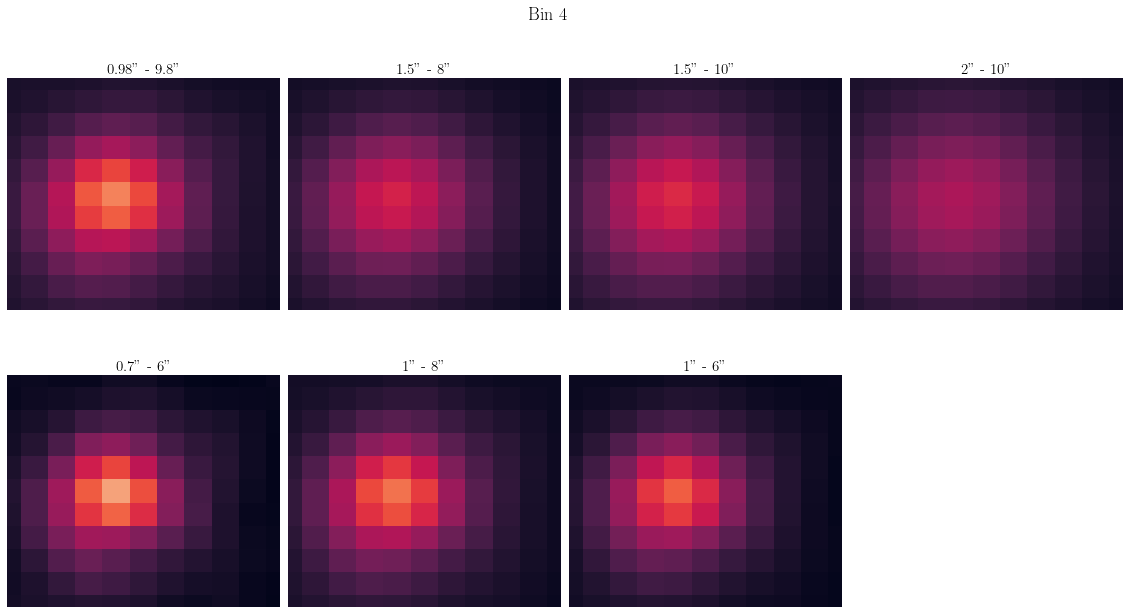

In [107]:
#draw
fig = plt.figure(figsize=(20, 10))
gs1 = GridSpec(2, 4)
gs1.update(wspace=0.03)

cmap=sns.color_palette("rocket", as_cmap=True)
chandra_zoom = [232.7940588,34.2402090, 10 * u.arcsec]

clim =[-1e-7, 3e-6]
data_maps = [unmsk_hdu.data for unmsk_hdu in um_b4_hdus]
data_hdrs = um_b4_hdrs
axs = []


# um_hdus, um_hdrs, um_wcs
for id_subplot in range(7):
    # um_hdus, um_hdrs, um_wcs
    data = data_maps[id_subplot]
    hdr = data_hdrs[id_subplot]

    ax = fig.add_subplot(gs1[id_subplot], projection=WCS(hdr))

    ax, cb = pf.ax_fits_map(hdu=None, data=data, hdr=hdr,
                        vmin=clim[0], vmax=clim[1], cmap=cmap, 
                        coords=chandra_zoom, ax=ax, contour=False, 
                        clip=None, lw=5, location='bottom', 
                        cbar=False)
    ax.set_title(um_labels[id_subplot])
    # #HST Contours: uncomment below lines if not in rush
    # pf.overlay(ax, hst_hdu, 1, vmin=0.05, vmax=0.5, nlev=10, contours=True, 
    #             cont_color='cyan', lw=1)
    ax.axis('off')
fig.suptitle("Bin 4")

### 3b.Different Unsharp Masks

It was created by dividing the image smoothed with a 0.98" radius Gaussian by one smoothed with a 9.8" Gaussian
- 0.98" - 9.8"
- 1.5" - 8"
- 1.5" - 10"
- 2" - 10"
- 0.7" - 6"
- 1" - 8"
- 1" - 6"
- 0.9" - 6"


In [ ]:
#

### 4. Soft, Medium and Hard X-Rays

to create the different bands do:

merge_obs "*/repro/*evt*[ccd_id=7]" merged/beads_xray_bin1 bin=1 bands=0.5:1:0.7

https://cxc.cfa.harvard.edu/ciao/ahelp/merge_obs.html

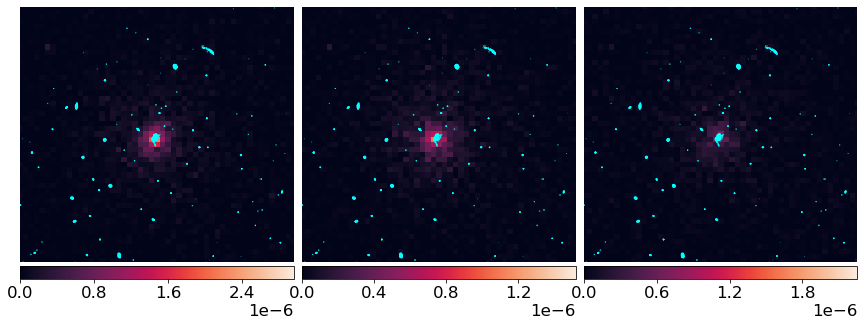

In [74]:
#draw
fig = plt.figure(figsize=(15, 5))
gs1 = GridSpec(1, 3)
gs1.update(wspace=0.03)

cmap=sns.color_palette("rocket", as_cmap=True)
chandra_zoom = [232.7940588,34.2402090, 50 * u.arcsec]

clims=[[None, None], [None, None], [None, None]]
data_maps = [csoft_hdu.data, cmed_hdu.data, chrd_hdu.data]
axs = []

for id_subplot in range(3):
    clim = clims[id_subplot]
    data = data_maps[id_subplot]

    ax = fig.add_subplot(gs1[id_subplot], projection=WCS(csmooth_hdr))

    ax = pf.ax_fits_map(hdu=None, data=data, hdr=csmooth_hdr,
                        vmin=clim[0], vmax=clim[1], cmap=cmap, 
                        coords=chandra_zoom, ax=ax, contour=False, 
                        clip=None, lw=5, location='bottom')

    #HST Contours: uncomment below lines if not in rush
    pf.overlay(ax, hst_hdu, 1, vmin=0.05, vmax=0.5, nlev=10, contours=True, 
                cont_color='cyan', lw=1)
    ax.axis('off')

### 5. Wavelet Fit

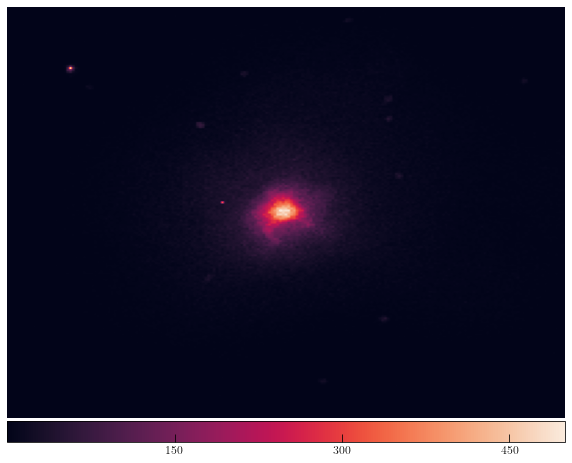

In [24]:
#draw
fig = plt.figure(figsize=(10, 8))
gs1 = GridSpec(1, 1)

cmap=sns.color_palette("rocket", as_cmap=True)
chandra_zoom = [232.7940588,34.2402090, 50 * u.arcsec]

clims=[[0, 500]]
data_maps = [cwav_hdu.data]
axs = []

for id_subplot in range(1):
    clim = clims[id_subplot]
    data = data_maps[id_subplot]

    ax = fig.add_subplot(gs1[id_subplot], projection=WCS(cwav_hdr))

    ax, cb = pf.ax_fits_map(hdu=None, data=data, hdr=cwav_hdr,
                        vmin=clim[0], vmax=clim[1], cmap=cmap, 
                        coords=chandra_zoom, ax=ax, contour=False, 
                        clip=None, lw=5, location='bottom')

    #HST Contours: uncomment below lines if not in rush
    # pf.overlay(ax, hst_hdu, 1, vmin=0., vmax=0.5, nlev=10, contours=True, 
    #             cont_color='cyan', lw=1)
    ax.axis('off')

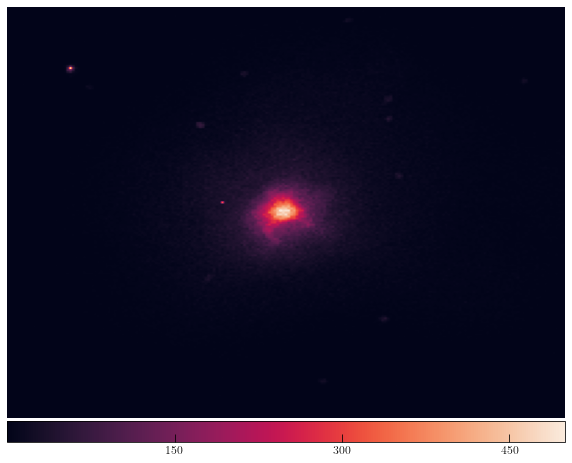

In [30]:
#draw
fig = plt.figure(figsize=(10, 8))
gs1 = GridSpec(1, 1)

cmap=sns.color_palette("rocket", as_cmap=True)
chandra_zoom = [232.7940588,34.2402090, 50 * u.arcsec]

clims=[[0, 500]]
data_maps = [cwav_hdu.data]
axs = []

for id_subplot in range(1):
    clim = clims[id_subplot]
    data = data_maps[id_subplot]

    ax = fig.add_subplot(gs1[id_subplot], projection=WCS(cwav_hdr))

    ax, cb = pf.ax_fits_map(hdu=None, data=data, hdr=cwav_hdr,
                        vmin=clim[0], vmax=clim[1], cmap=cmap, 
                        coords=chandra_zoom, ax=ax, contour=False, 
                        clip=None, lw=5, location='bottom')

    #HST Contours: uncomment below lines if not in rush
    # pf.overlay(ax, hst_hdu, 1, vmin=0., vmax=0.5, nlev=10, contours=True, 
    #             cont_color='cyan', lw=1)
    ax.axis('off')

### 6. Quantify size of wings in surface brightness image

In [ ]:
#ds9 
# left wing is 6.721"
# right wing is 4.546" 

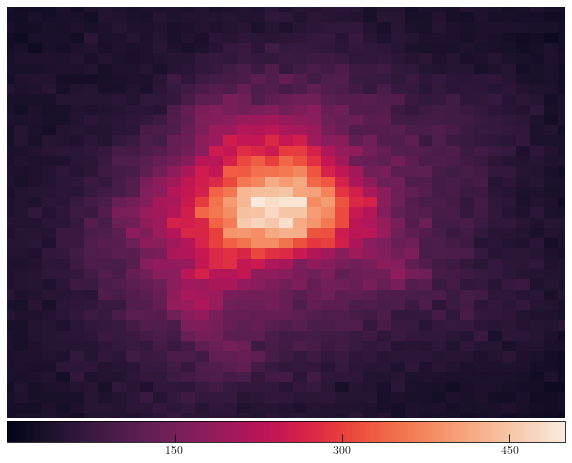

In [42]:
#draw
fig = plt.figure(figsize=(10, 8))
gs1 = GridSpec(1, 1)

cmap=sns.color_palette("rocket", as_cmap=True)
chandra_zoom = [232.7940588,34.2402090, 10 * u.arcsec]

clims=[[0, 500]]
data_maps = [cwav_hdu.data]
axs = []

for id_subplot in range(1):
    clim = clims[id_subplot]
    data = data_maps[id_subplot]

    ax = fig.add_subplot(gs1[id_subplot], projection=WCS(cwav_hdr))

    ax, cb = pf.ax_fits_map(hdu=None, data=data, hdr=cwav_hdr,
                        vmin=clim[0], vmax=clim[1], cmap=cmap, 
                        coords=chandra_zoom, ax=ax, contour=False, 
                        clip=None, lw=5, location='bottom')

    #HST Contours: uncomment below lines if not in rush
    # pf.overlay(ax, hst_hdu, 1, vmin=0., vmax=0.5, nlev=10, contours=True, 
    #             cont_color='cyan', lw=1)
    ax.axis('off')

In [44]:
right_wing_kpc = 4.546 * u.arcsec * kpc_per_arcsec
left_wing_kpc = 6.721 * u.arcsec * kpc_per_arcsec

In [45]:
print("Right wing length: {:.2f}".format(right_wing_kpc))
print("Left wing length: {:.2f}".format(left_wing_kpc))

Right wing length: 21.67 kpc
Left wing length: 32.04 kpc


### 7. If space ebtween wings is a cavity, was the heat released enoug to mitgate ICM cooling?

In [11]:
specfit_savepath = path_to_beads + 'Analysis/chandraBeads/ciao_spectra_results/'
cel_flux = np.load(specfit_savepath + 'cf_60.npy')
cel_flux_err = np.load(specfit_savepath + 'cf_err_60.npy')

In [12]:
#KT and norm
kTs = np.load(specfit_savepath + 'kTs_60.npy') * u.keV
kT_errs = np.load(specfit_savepath + 'kT_err_60.npy') * u.keV
norms = np.load(specfit_savepath + 'norms_60.npy')
norm_errs = np.load(specfit_savepath + 'norm_errs_60.npy')


radius_df = pd.DataFrame(np.load(specfit_savepath + 'radius_60.npy'), columns=['radius', 
                            'radius_err', 'r_inner', 'r_outer'])

r_inner_in_kpc = radius_df['r_inner'].to_numpy() * u.kpc 
r_outer_in_kpc = radius_df['r_outer'].to_numpy() * u.kpc 
radius_to_plot = radius_df['radius'].to_numpy() * u.kpc 
radius_err_to_plot = radius_df['radius_err'].to_numpy() * u.kpc 

volume = (4/3) * scipy.pi * (r_outer_in_kpc**3 - r_inner_in_kpc**3)

#electron density
electron_density = np.sqrt((norms * u.cm**-5 * 4 * np.pi * 
                            np.power(angular_diameter_distance.to(u.cm) * (1 + zh), 2)) 
                            / (1.e-14 * 0.82 * volume.to(u.cm**3))) 
electron_density_err = electron_density / (2*norms) * norm_errs

#pressure
pressure = (2 * electron_density * kTs).to(u.dyne/u.cm**2)
pressure_err  = pressure * sf.dm_error_prop([electron_density, kTs], [electron_density_err, kT_errs])

#entropy
entropy  = kTs * np.power(electron_density, -2.0/3.0)
entropy_err = entropy * sf.dm_error_prop([kTs.value, np.power(electron_density, -2/3).value], 
                [kT_errs.value, sf.exp_error_prop(electron_density, electron_density_err, -2/3) ])

#cooling time
cooling_time = sf.tcool(electron_density, kTs)
cool_func_err = sf.dm_error_prop([kTs**-1.7, kTs**0.5], [sf.exp_error_prop(kTs, kT_errs, -1.7), 
                    sf.exp_error_prop(kTs, kT_errs, 0.5)]) * sf.coolingFunction(kTs)

cooling_time_err = cooling_time * sf.dm_error_prop([pressure.value, np.power(electron_density, 2).value, sf.coolingFunction(kTs).value],
                    [pressure_err.value, sf.exp_error_prop(electron_density, electron_density_err, 2).value, cool_func_err])

In [13]:
luminosity  = cel_flux * u.erg / u.s / u.cm**2  * 4.0 * np.pi * np.power(cosmo.luminosity_distance(zh), 2) # in erg/s
luminosity_err  = luminosity * scipy.log(10) * cel_flux_err

scipy.log is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.log instead


In [21]:
(cel_flux * u.erg / u.s / u.cm**2)[3]

<Quantity 1.4321475e-07 erg / (cm2 s)>

In [23]:
np.power(cosmo.luminosity_distance(zh), 1)

<Quantity 1752.43628481 Mpc>

In [18]:
luminosity.to(u.erg/u.s)[3]

<Quantity 5.26239177e+49 erg / s>

In [17]:
cooling_time.to(u.Gyr)[3]

<Quantity 2.40977127 Gyr>

In [86]:
luminosity.to(u.erg/u.s)[-1=]

<Quantity 1.74922275e+48 erg / s>

In [27]:
radius_to_plot [3]

<Quantity 40.19841673 kpc>

In [74]:
a_cavity = 1.906 * u.arcsec * kpc_per_arcsec
b_cavity = 3.158 * u.arcsec * kpc_per_arcsec
c_cavity = 17 * u.kpc#9.825 * u.arcsec * kpc_per_arcsec
rad_cavity = 2.868 * u.arcsec * kpc_per_arcsec
R_cavity = 4.338 * u.arcsec * kpc_per_arcsec
volume_cavity = (4/3) * np.pi * np.power(b_cavity,2) * a_cavity #* b_cavity #r_cavity**3 #
area_cavity = 4 * np.pi *  a_cavity * b_cavity

In [52]:
a_cavity, b_cavity, c_cavity

(<Quantity 9.08609909 kpc>, <Quantity 15.05451255 kpc>, <Quantity 17. kpc>)

In [65]:
R_cavity

<Quantity 20.67969456 kpc>

In [67]:
radius_to_plot

<Quantity [  9.47903347,  11.87939027,  26.03818354,  40.19841673,
            54.35721001,  68.51600328,  82.67623648,  96.83502975,
           110.99382302, 125.15405622, 139.31284949, 153.47164276,
           167.63187596, 181.79066923, 195.9494625 , 210.1096957 ,
           224.26848897, 238.42728224, 252.58751544, 266.74630871,
           280.90510198] kpc>

In [68]:
pressure[2]

<Quantity 3.1470117e-10 dyn / cm2>

In [62]:
70/(6.8*2.9)

3.5496957403651117

In [63]:
(6.8 *2.9 * (4/3) * np.pi )

82.60294283838762

In [69]:
pressure_cavity = pressure[2]

In [75]:
energy_cavity = 4 * pressure_cavity * volume_cavity

In [87]:
vstar = 350 * u.km/u.s
grav_accel = 2 * np.power(vstar, 2)/R_cavity
v_terminal = np.sqrt((2 * grav_accel * volume_cavity)/(0.75 * area_cavity))

In [88]:
t_cavity = R_cavity/v_terminal
e_cavity = 4 * pressure_cavity * volume_cavity

In [90]:
t_cavity.to(u.year)/1e7

<Quantity 5.07834999 yr>

In [91]:
energy_cavity.cgs

<Quantity 3.19013791e+59 erg>

In [92]:
power_cavity = energy_cavity/t_cavity

In [93]:
power_cavity.cgs

<Quantity 1.99059479e+44 erg / s>

In [94]:
pressure_cavity

<Quantity 3.1470117e-10 dyn / cm2>

In [95]:
15/(2 + np.sqrt(2))

4.393398282201788

In [21]:
m500 = 1.9e14 * u.solMass
r500 = 779 * u.kpc
g = ((m500 * const.G)/r500**2)

In [22]:
t_cavity = 1 * np.sqrt(np.sqrt(a_cavity * b_cavity)/g)

In [23]:
power_cavity = enthalpy_cavity/t_cavity

In [24]:
power_cavity.cgs

<Quantity 1.65513128e+37 erg / s>

8. Counts per annulus

dmlist "v17218_flux_rprofile.fits[HISTOGRAM][cols counts,net_counts]" data